## Lab 1

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Width: 4


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


PTQ Evaluation accuracy: 0.5


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


QAT Evaluation accuracy: 0.5
---------------------------------------------------------
Width: 6


PTQ Evaluation accuracy: 0.6646


Step,Training Loss
500,0.559900
1000,0.448200
1500,0.439500
2000,0.434500
2500,0.422400
3000,0.414400


QAT Evaluation accuracy: 0.8312
---------------------------------------------------------
Width: 8


PTQ Evaluation accuracy: 0.8236


Step,Training Loss
500,0.418600
1000,0.398900
1500,0.396700
2000,0.408600
2500,0.386500
3000,0.383900


QAT Evaluation accuracy: 0.84204
---------------------------------------------------------
Width: 10


PTQ Evaluation accuracy: 0.8314


Step,Training Loss
500,0.417000
1000,0.388200
1500,0.393600
2000,0.401400
2500,0.387700
3000,0.386200


QAT Evaluation accuracy: 0.84172
---------------------------------------------------------
Width: 12


PTQ Evaluation accuracy: 0.83424


Step,Training Loss
500,0.415800
1000,0.384600
1500,0.391500
2000,0.401600
2500,0.384200
3000,0.383800


QAT Evaluation accuracy: 0.84212
---------------------------------------------------------
Width: 14


PTQ Evaluation accuracy: 0.83512


Step,Training Loss
500,0.415500
1000,0.384000
1500,0.393200
2000,0.401300
2500,0.382500
3000,0.383600


QAT Evaluation accuracy: 0.84184
---------------------------------------------------------
Width: 16


PTQ Evaluation accuracy: 0.83548


Step,Training Loss
500,0.414300
1000,0.383700
1500,0.391800
2000,0.401600
2500,0.383700
3000,0.383600


QAT Evaluation accuracy: 0.84176
---------------------------------------------------------
Width: 18


PTQ Evaluation accuracy: 0.83576


Step,Training Loss
500,0.414800
1000,0.383700
1500,0.392000
2000,0.401700
2500,0.383300
3000,0.383200


QAT Evaluation accuracy: 0.84184
---------------------------------------------------------
Width: 20


PTQ Evaluation accuracy: 0.83564


Step,Training Loss
500,0.414800
1000,0.383500
1500,0.391800
2000,0.401600
2500,0.383400
3000,0.383100


QAT Evaluation accuracy: 0.8424
---------------------------------------------------------
Width: 22


PTQ Evaluation accuracy: 0.83608


Step,Training Loss
500,0.414900
1000,0.383500
1500,0.391600
2000,0.401900
2500,0.383100
3000,0.383300


QAT Evaluation accuracy: 0.8424
---------------------------------------------------------
Width: 24


PTQ Evaluation accuracy: 0.83592


Step,Training Loss
500,0.414900
1000,0.383500
1500,0.391800
2000,0.401800
2500,0.383200
3000,0.383300


QAT Evaluation accuracy: 0.84252
---------------------------------------------------------
Width: 26


PTQ Evaluation accuracy: 0.83608


Step,Training Loss
500,0.414900
1000,0.383500
1500,0.391800
2000,0.401800
2500,0.383200
3000,0.383300


QAT Evaluation accuracy: 0.84244
---------------------------------------------------------
Width: 28


PTQ Evaluation accuracy: 0.83604


Step,Training Loss
500,0.414900
1000,0.383500
1500,0.391800
2000,0.401800
2500,0.383200
3000,0.383300


QAT Evaluation accuracy: 0.84244
---------------------------------------------------------
Width: 30


PTQ Evaluation accuracy: 0.83588


Step,Training Loss
500,0.414900
1000,0.383500
1500,0.391800
2000,0.401800
2500,0.383200
3000,0.383300


QAT Evaluation accuracy: 0.84252
---------------------------------------------------------
Width: 32


PTQ Evaluation accuracy: 0.83584


Step,Training Loss
500,0.414900
1000,0.383500
1500,0.391800
2000,0.401800
2500,0.383200
3000,0.383300


INFO     Exporting MaseGraph to lab1_qat_best.pt, lab1_qat_best.mz
INFO     Exporting GraphModule to lab1_qat_best.pt


QAT Evaluation accuracy: 0.84252
---------------------------------------------------------
Results saved to lab1_quantization_results.json


INFO     Exporting MaseMetadata to lab1_qat_best.mz


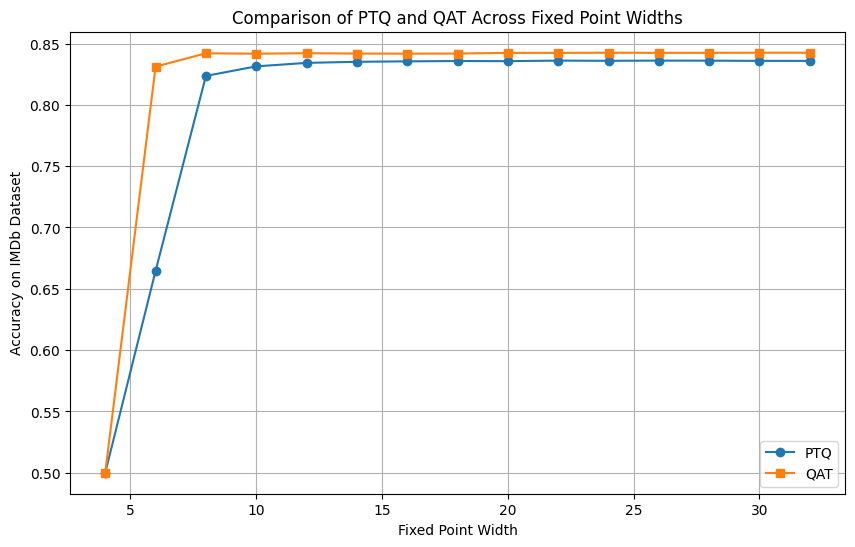

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import json  # 用于保存结果
from pathlib import Path
from chop import MaseGraph
from chop.tools import get_tokenized_dataset, get_trainer
import chop.passes as passes

tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

# Fixed point widths
fixed_point_widths = range(4, 34, 2)
# Record accuracy
ptq_accuracies = []
qat_accuracies = []
max_qat_acc = float('-inf')
best_mg = None

for width in fixed_point_widths:
    print(f"Width: {width}")
    quant_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": width,
                "data_in_frac_width": width // 2,
                # weight
                "weight_width": width,
                "weight_frac_width": width // 2,
                # bias
                "bias_width": width,
                "bias_frac_width": width // 2,
            }
        },
    }
    mg = MaseGraph.from_checkpoint("tutorial_2_lora")
    mg, _ = passes.quantize_transform_pass(
        mg,
        pass_args=quant_config,
    )
    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )
    # PTQ
    ptq_acc = trainer.evaluate()
    ptq_accuracies.append(ptq_acc['eval_accuracy'])
    print(f"PTQ Evaluation accuracy: {ptq_acc['eval_accuracy']}")
    
    # QAT:
    trainer.train()
    qat_acc = trainer.evaluate()
    qat_accuracies.append(qat_acc['eval_accuracy'])
    print(f"QAT Evaluation accuracy: {qat_acc['eval_accuracy']}")

    if qat_acc['eval_accuracy'] > max_qat_acc:
        max_qat_acc = qat_acc['eval_accuracy']
        best_mg = mg

    print("---------------------------------------------------------")

# 保存 PTQ 和 QAT 的精度结果
results = {
    "fixed_point_widths": list(fixed_point_widths),
    "ptq_accuracies": ptq_accuracies,
    "qat_accuracies": qat_accuracies
}

# 保存到 JSON 文件
output_file = "lab1_quantization_results.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=4)
print(f"Results saved to {output_file}")

# 导出最佳模型
best_mg.export("lab1_qat_best")

# 绘制曲线图
plt.figure(figsize=(10, 6))
plt.plot(fixed_point_widths, ptq_accuracies, label="PTQ", marker="o")
plt.plot(fixed_point_widths, qat_accuracies, label="QAT", marker="s")
plt.xlabel("Fixed Point Width")
plt.ylabel("Accuracy on IMDb Dataset")
plt.title("Comparison of PTQ and QAT Across Fixed Point Widths")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from chop.tools import get_tokenized_dataset, get_trainer
import matplotlib.pyplot as plt
import numpy as np
import json
import torch

# 定义稀疏度范围
sparsity_levels = np.arange(0.1, 1.0, 0.1)  # 从 0.1 到 0.9，步长为 0.1

# 用于记录每种方法的精度
random_accuracies = []
l1_norm_accuracies = []
max_acc = float('-inf')
best_model = None

# 剪枝方法
pruning_methods = ["random", "l1-norm"]

# 加载数据集
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

for sparsity in sparsity_levels:
    for method in pruning_methods:
        # 配置剪枝参数
        pruning_config = {
            "weight": {
                "sparsity": sparsity,  # 当前稀疏度
                "method": method,      # 剪枝方法：random 或 l1-norm
                "scope": "local",      # 剪枝范围：局部（每层单独处理）
            },
            "activation": {
                "sparsity": sparsity,
                "method": method,
                "scope": "local",
            },
        }
        # 加载模型
        mg = MaseGraph.from_checkpoint("lab1_qat_best")
        # 应用剪枝
        pruned_mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"device: {device}")
        pruned_mg.model.to(device)

        trainer = get_trainer(
            model=pruned_mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=5,
        )
        trainer.train()
        # 评估剪枝后的模型精度
        eval_results = trainer.evaluate()
        acc = eval_results['eval_accuracy']
        print(f"Sparsity: {sparsity}, method: {method}, acc: {acc}")

        if acc > max_acc:
            max_acc = acc
            best_model = pruned_mg
            print(f"Best model: Sparsity: {sparsity}, method: {method}, acc: {acc}")


        # 根据剪枝方法记录精度
        if method == "random":
            random_accuracies.append(acc)
        elif method == "l1-norm":
            l1_norm_accuracies.append(acc)
        
        print("------------------------------------------------------------------")

# 保存结果到文件
results = {
    "sparsity_levels": sparsity_levels.tolist(),
    "random_accuracies": random_accuracies,
    "l1_norm_accuracies": l1_norm_accuracies,
}

with open("lab1_pruning_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("Pruning results saved to lab1_pruning_results.json")

# 导出最佳模型
best_model.export("lab1_prun_best")

# 绘制剪枝策略的精度曲线
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, random_accuracies, label="Random Pruning", marker="o")
plt.plot(sparsity_levels, l1_norm_accuracies, label="L1-Norm Pruning", marker="s")
plt.xlabel("Sparsity")
plt.ylabel("Accuracy on IMDb Dataset")
plt.title("Impact of Pruning Strategies on Model Accuracy")
plt.legend()
plt.grid(True)
plt.show()

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_en

device: cuda


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.464600
1000,0.429700
1500,0.437100
2000,0.429100
2500,0.416900
3000,0.430900
3500,0.418900
4000,0.422700
4500,0.407100
5000,0.407700


Sparsity: 0.1, method: random, acc: 0.8372
Best model: Sparsity: 0.1, method: random, acc: 0.8372
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.375600
1000,0.378900
1500,0.379000
2000,0.387200
2500,0.380700
3000,0.395500
3500,0.379000
4000,0.383800
4500,0.372000
5000,0.377000


Sparsity: 0.1, method: l1-norm, acc: 0.86012
Best model: Sparsity: 0.1, method: l1-norm, acc: 0.86012
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.573000
1000,0.485400
1500,0.466600
2000,0.462500
2500,0.456200
3000,0.455300
3500,0.451200
4000,0.448200
4500,0.439600
5000,0.432600


Sparsity: 0.2, method: random, acc: 0.8188
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.375200
1000,0.371200
1500,0.375000
2000,0.385100
2500,0.379500
3000,0.394300
3500,0.381600
4000,0.383200
4500,0.370400
5000,0.374400


Sparsity: 0.2, method: l1-norm, acc: 0.858
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.672500
1000,0.605800
1500,0.531600
2000,0.505500
2500,0.495500
3000,0.492500
3500,0.487400
4000,0.479300
4500,0.465300
5000,0.451500


Sparsity: 0.30000000000000004, method: random, acc: 0.80428
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.381500
1000,0.372100
1500,0.377500
2000,0.383900
2500,0.379200
3000,0.395900
3500,0.386500
4000,0.386900
4500,0.373100
5000,0.378700


Sparsity: 0.30000000000000004, method: l1-norm, acc: 0.85232
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.690900
1000,0.688800
1500,0.679400
2000,0.651900
2500,0.595100
3000,0.562800
3500,0.539900
4000,0.532100
4500,0.514300
5000,0.495800


Sparsity: 0.4, method: random, acc: 0.78432
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.401300
1000,0.388400
1500,0.385500
2000,0.395500
2500,0.391800
3000,0.397100
3500,0.394500
4000,0.396200
4500,0.381200
5000,0.387700


Sparsity: 0.4, method: l1-norm, acc: 0.84476
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.692700
1000,0.694600
1500,0.692500
2000,0.692800
2500,0.691600
3000,0.691900
3500,0.689500
4000,0.690800
4500,0.686800
5000,0.685100


Sparsity: 0.5, method: random, acc: 0.7272
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.454000
1000,0.416200
1500,0.405500
2000,0.414800
2500,0.408200
3000,0.414600
3500,0.416800
4000,0.406200
4500,0.395300
5000,0.397900


Sparsity: 0.5, method: l1-norm, acc: 0.83648
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.692400
1000,0.694100
1500,0.693200
2000,0.693000
2500,0.692500
3000,0.693600
3500,0.692800
4000,0.693400
4500,0.692100
5000,0.693300


Sparsity: 0.6, method: random, acc: 0.52508
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.551700
1000,0.470300
1500,0.437300
2000,0.435900
2500,0.426000
3000,0.435100
3500,0.430900
4000,0.421200
4500,0.408400
5000,0.415300


Sparsity: 0.6, method: l1-norm, acc: 0.823
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.692800
1000,0.693600
1500,0.693400
2000,0.693200
2500,0.693100
3000,0.693400
3500,0.693300
4000,0.693100
4500,0.693000
5000,0.693400


Sparsity: 0.7000000000000001, method: random, acc: 0.49696
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.653500
1000,0.614800
1500,0.567700
2000,0.519400
2500,0.486100
3000,0.476800
3500,0.472600
4000,0.461300
4500,0.440300
5000,0.447800


Sparsity: 0.7000000000000001, method: l1-norm, acc: 0.81132
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.693100
1000,0.693200
1500,0.693100
2000,0.693100
2500,0.693200
3000,0.693200
3500,0.693100
4000,0.693200
4500,0.693200
5000,0.693100


Sparsity: 0.8, method: random, acc: 0.4944
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.688800
1000,0.686300
1500,0.682800
2000,0.675000
2500,0.672600
3000,0.666200
3500,0.661400
4000,0.655100
4500,0.640600
5000,0.636700


Sparsity: 0.8, method: l1-norm, acc: 0.73616
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.693200
1000,0.693100
1500,0.693100
2000,0.693200
2500,0.693200
3000,0.693200
3500,0.693100
4000,0.693100
4500,0.693200
5000,0.693200


Sparsity: 0.9, method: random, acc: 0.498
------------------------------------------------------------------


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


device: cuda


Step,Training Loss
500,0.692400
1000,0.692300
1500,0.692700
2000,0.692100
2500,0.692500
3000,0.692600
3500,0.692100
4000,0.691800
4500,0.691500
5000,0.691000


INFO     Exporting MaseGraph to lab1_prun_best.pt, lab1_prun_best.mz
INFO     Exporting GraphModule to lab1_prun_best.pt


Sparsity: 0.9, method: l1-norm, acc: 0.59016
------------------------------------------------------------------
Pruning results saved to lab1_pruning_results.json


RuntimeError: Serialization of parametrized modules is only supported through state_dict(). See:
https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training

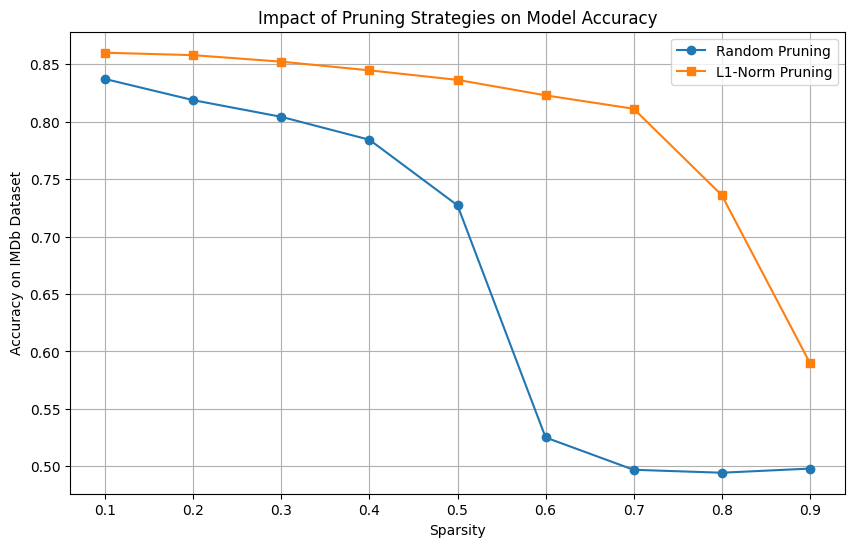

In [11]:
import json
import matplotlib.pyplot as plt

# 读取 JSON 文件
input_file = "lab1_pruning_results.json"
with open(input_file, "r") as f:
    results = json.load(f)

# 从 JSON 数据中提取信息
sparsity_levels = results["sparsity_levels"]
random_accuracies = results["random_accuracies"]
l1_norm_accuracies = results["l1_norm_accuracies"]

# 转换 sparsity_levels 为浮点数（确保数据格式正确）
sparsity_levels = [float(s) for s in sparsity_levels]

# 绘制剪枝策略的精度曲线
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, random_accuracies, label="Random Pruning", marker="o")
plt.plot(sparsity_levels, l1_norm_accuracies, label="L1-Norm Pruning", marker="s")
plt.xlabel("Sparsity")
plt.ylabel("Accuracy on IMDb Dataset")
plt.title("Impact of Pruning Strategies on Model Accuracy")
plt.legend()
plt.grid(True)
plt.show()